In [1]:
import numpy as np
import matplotlib.pyplot as plt

from impulse import PTSampler

%load_ext autoreload
%autoreload 2

In [2]:
def sinusoidal_model(params, t):
    # params: array of shape (N, 3)
    # t: array of shape (T,)
    if params.ndim == 1:
        A, f, phi = params
    else:
        A = params[:, 0][:, np.newaxis]  # Shape (N, 1)
        f = params[:, 1][:, np.newaxis]
        phi = params[:, 2][:, np.newaxis]
        t = t[np.newaxis, :]  # Shape (1, T)
    # Compute the sinusoidal model outputs
    y = A * np.sin(2 * np.pi * f * t + phi)  # Shape (N, T)
    return y

class VectorizedLnLikelihood:
    def __init__(self, t, data, sigma=1):
        self.t = t
        self.data = data
        self.sigma = sigma

    def __call__(self, params):
        # Determine the number of parameter sets
        N = params.shape[0] // 3
        # Reshape params to (N, 3)
        params = params.reshape(N, 3)
        # Compute the model outputs for all parameter sets
        y = sinusoidal_model(params, self.t)  # Shape (N, T)
        # Compute residuals
        residuals = self.data - y  # Broadcasting over N
        # Compute chi-squared values for each parameter set
        chi2 = np.sum((residuals / self.sigma) ** 2, axis=1)  # Sum over time points
        # Return an array of likelihoods
        return -0.5 * chi2


def vectorized_log_prior(params):
    """
    Computes the log prior probability of the parameters for the sinusoidal model.

    Parameters:
    - params: A NumPy array of shape (n*3,), where n is the number of sine waves.
              The array contains amplitudes, frequencies, and phases in the order:
              [A1, f1, φ1, A2, f2, φ2, ..., An, fn, φn]

    Returns:
    - log_p: 0.0 if all parameters are within the prior ranges, -np.inf otherwise.
    """
    params = np.asarray(params)

    if params.size % 3 != 0:
        # The number of parameters must be a multiple of 3
        print("Error: Parameter array length must be a multiple of 3.")
        return -np.inf

    # Reshape parameters to separate amplitudes, frequencies, and phases
    params = params.reshape(-1, 3)
    A = params[:, 0]    # Amplitudes
    f = params[:, 1]    # Frequencies
    phi = params[:, 2]  # Phases

    result = np.zeros_like(A)
    # Check amplitude ranges
    result += np.where((A < 0) | (A > 5), -np.inf, 0.0)
    # Check frequency ranges
    result += np.where((f < 0) | (f > 3), -np.inf, 0.0)
    # Check phase ranges
    result += np.where((phi < 0) | (phi > np.pi), -np.inf, 0.0)
    return result


def make_sinusoidal_data(num_pts):
    rng = np.random.default_rng()

    freq_real = 3 * rng.uniform(0, 1)
    amp_real = 5 * rng.uniform(0, 1)
    phase_real = np.pi * rng.uniform(0, 1)

    x = np.linspace(0, 2*np.pi, num_pts)
    data = rng.standard_normal(num_pts) + sinusoidal_model(np.array([amp_real, freq_real, phase_real]), x)
    return x, data, [amp_real, freq_real, phase_real]

### Simulate data with signal and noise

Let's simulate some data as

$d_i(t) = n_i + s_i(t)\, ,$

with

$n_i \sim \mathcal{N}(0, 1)\, ,$

where $d_i(t)$ are the i-th data point, $n_i$ is the noise, and $s_i(t)$ is the signal. The signal is

$s_i\left([A, f, \phi]; t\right) = A \sin(2\pi f t + \phi)$.

In [60]:
x, data, real_vals = make_sinusoidal_data(500)
amp_real, freq_real, phase_real = real_vals

### Plot the data

injected [amplitude, frequency, phase] = [4.70293239339549, 0.3804299404401865, 0.4078489400972059]


Text(0.5, 0, 'Time [s]')

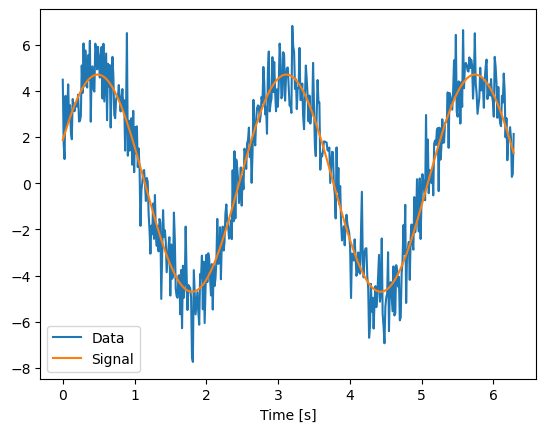

In [61]:
print('injected [amplitude, frequency, phase] =', real_vals)
plt.plot(x, data, label='Data')
plt.plot(x, sinusoidal_model(np.array(real_vals), x), label='Signal')
plt.legend()
plt.xlabel('Time [s]')

Now we'll do a grid approximation of the likelihood function to get the posterior distribution of the parameters $A$, $f$, and $\phi$.

In [71]:
lnlikelihood = VectorizedLnLikelihood(x, data)
sampler = PTSampler(3, lnlikelihood, vectorized_log_prior, ntemps=20, swap_steps=10, inf_temp=True, vectorized=True)
# sampler = PTSampler(3, lnlikelihood, vectorized_log_prior, ntemps=10, swap_steps=10, inf_temp=True, vectorized=False)

In [72]:
lnlikelihood(np.repeat([1, 1, 1], 20))

array([-3415.79824849, -3415.79824849, -3415.79824849, -3415.79824849,
       -3415.79824849, -3415.79824849, -3415.79824849, -3415.79824849,
       -3415.79824849, -3415.79824849, -3415.79824849, -3415.79824849,
       -3415.79824849, -3415.79824849, -3415.79824849, -3415.79824849,
       -3415.79824849, -3415.79824849, -3415.79824849, -3415.79824849])

In [73]:
# linear scaling with number of temperatures when likelihood is fast
sampler.sample(np.repeat([1, 1, 1], 20), num_iterations=100_000, thin=10)
# sampler.sample([1, 1, 1], num_iterations=100_000, thin=10)

100%|██████████| 100000/100000 [01:10<00:00, 1412.86it/s]


In [30]:
chains = []
for ii in range(sampler.ntemps):
    with open(sampler.outdir + f'/chain_{ii}.txt') as fp:
        chains.append(np.loadtxt(fp))

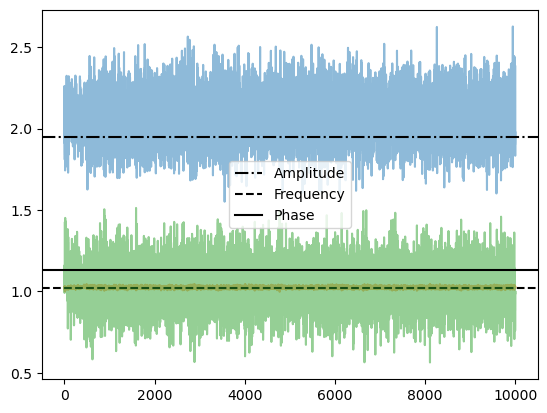

In [31]:
plt.plot(chains[0][:, 0], alpha = 0.5)
plt.axhline(amp_real, color='k', linestyle='-.', label="Amplitude")
plt.plot(chains[0][:, 1], alpha = 0.5)
plt.axhline(freq_real, color='k', linestyle='--', label="Frequency")
plt.plot(chains[0][:, 2], alpha = 0.5)
plt.axhline(phase_real, color='k', linestyle='-', label="Phase")
plt.legend()

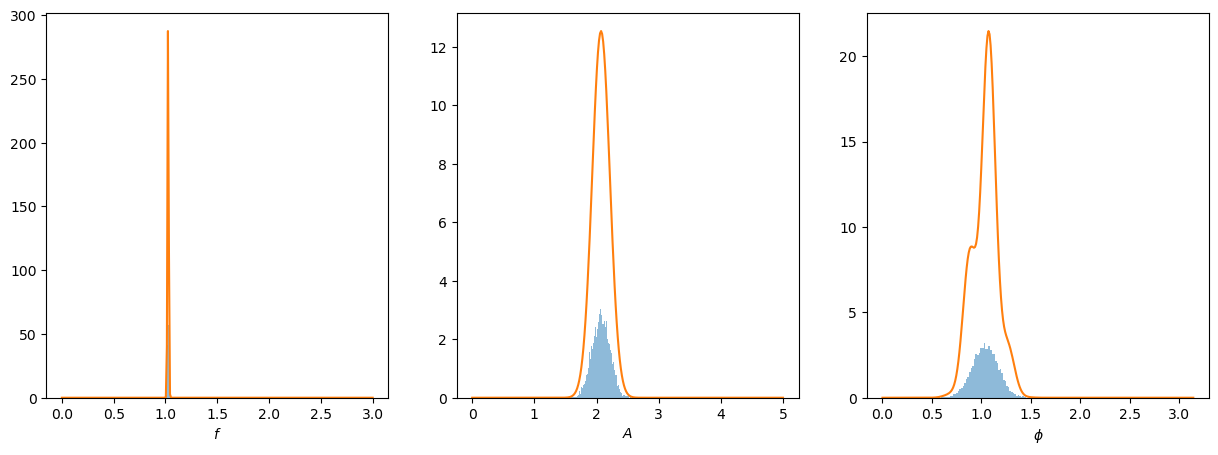

In [32]:
chain_idx = 0
temp = sampler.ptstate.ladder[chain_idx]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(chains[chain_idx][:, 1], alpha=0.5, bins=70, density=True)
ax[0].plot(freq, freq_post / 1.2)
ax[0].set_xlabel(r'$f$')

ax[1].hist(chains[chain_idx][:, 0], alpha=0.5, bins=100, density=True)
ax[1].plot(amp, amp_post / 2)
ax[1].set_xlabel(r'$A$')

ax[2].hist(chains[chain_idx][:, 2], alpha=0.5, bins='auto', density=True)
ax[2].plot(phi, phi_post)
ax[2].set_xlabel(r'$\phi$')
plt.show()

In [37]:
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

In [38]:
outDir = './chains/'

sampler = ptmcmc(3, lnlikelihood, vectorized_log_prior, cov=np.diag([1, 1, 1]), outDir=outDir)

In [39]:
sampler.sample(np.array([1, 1, 1], dtype=np.float64), 1e6, SCAMweight=30, AMweight=15, DEweight=50, )

Finished 1.00 percent in 0.465727 s Acceptance rate = 0.904654Adding DE jump with weight 50
Finished 100.00 percent in 45.725330 s Acceptance rate = 0.739076
Run Complete


In [40]:
with open('./chains/chain_1.txt', 'r') as fp:
    chain = np.loadtxt(fp)

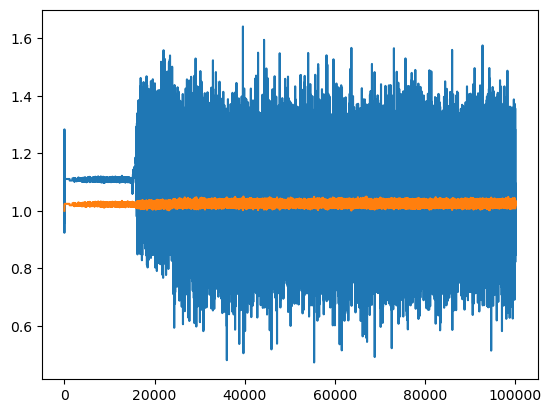

In [41]:
plt.plot(chain[:, 2])
plt.plot(chain[:, 1])

In [258]:
chain.shape

(100001, 7)

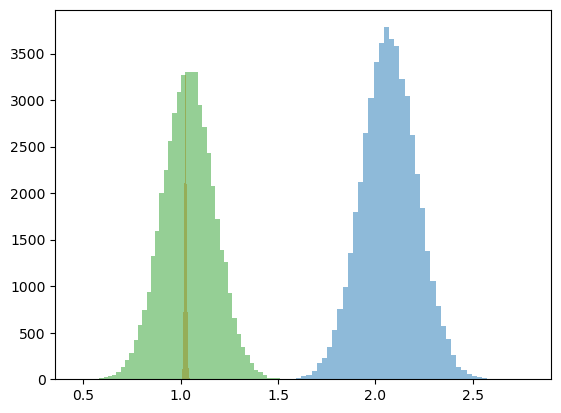

In [43]:
plt.hist(chain[50_000:, 0], bins=50, alpha=0.5)
plt.hist(chain[50_000:, 1], bins=50, alpha=0.5)
plt.hist(chain[50_000:, 2], bins=50, alpha=0.5);

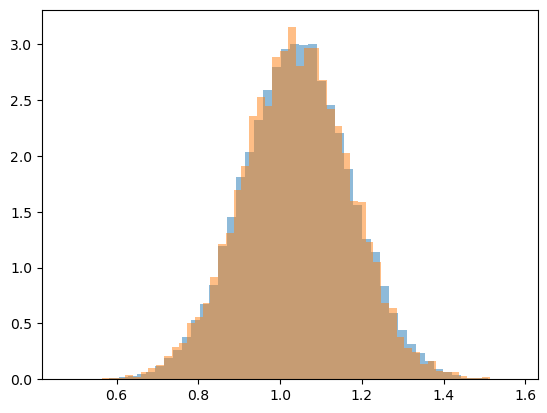

In [47]:
plt.hist(chain[50_000:, 2], bins=50, alpha=0.5, density=True);
plt.hist(chains[chain_idx][:, 2], alpha=0.5, bins=50, density=True);